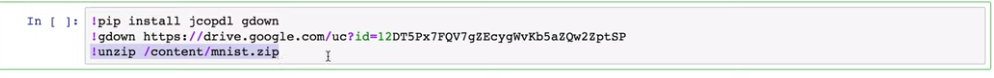

In [ ]:
# !pip install jcopdl gdown
# !gdown https://drive.google.com/uc?id=12DT5Px7gZEcygWvKb5aZQw2zptSP
# !unzip /content/mnist.zip

In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Dataset & DataLoader (Hanya Train Set)

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

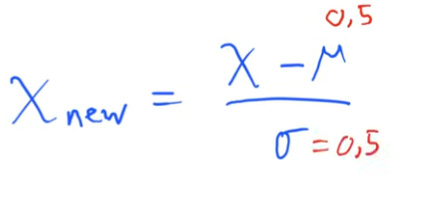

In [5]:
bs = 64


train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # agar menjadi -1 sampai 1 agar menjadi lebih stabil
])

train_set = datasets.ImageFolder("data/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/train'

# Arsitektur & Config 

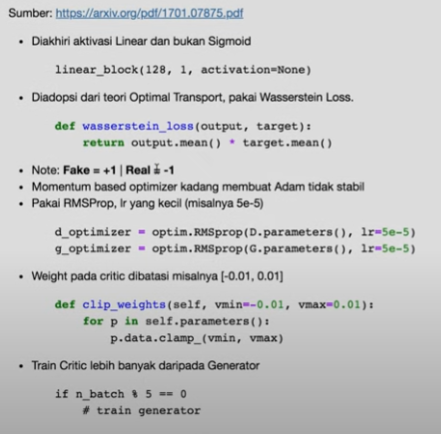

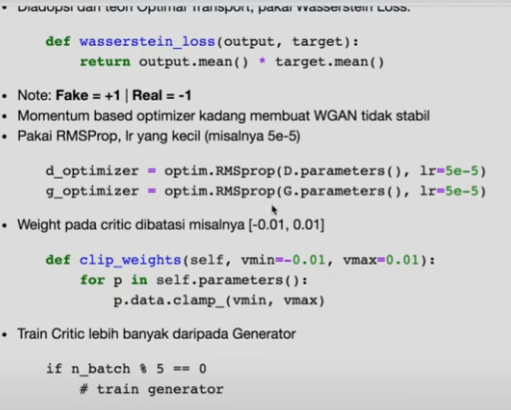

In [3]:
%%writefile model_wgan.py
import torch 
from torch import nn
from jcopdl.layers import linear_block


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(784, 512, activation='lrelu'), #hindari angka 0 yaitu ReLu banyak angka 0 sparse
            linear_block(512, 256, activation='lrelu'),
            linear_block(256, 128, activation='lrelu'),
            linear_block(128, 1, activation='None')
        ),
    
    def forward(self, x):
        return self.fc(x)

    def clip_weights(self, vmin=-0.01, vmax=0.01):
        for p in self.parameters():
            p.data.clamp_(vmin, vmax)

    
class Generator(nn.Module):
    def __init__(self, z_dim): #z_dim = lattent space
        super().__init__()
        self.z_dim = z_dim
        self.fc = nn.Sequential(
            linear_block(z_dim, 128, activation='lrelu'),
            linear_block(128, 256, activation='lrelu', batch_norm=True), #hindari angka 0 yaitu ReLu banyak angka 0 sparse
            linear_block(256, 512, activation='lrelu', batch_norm=True), # batch norm agar training lebih stabil
            linear_block(512, 1024, activation='lrelu', batch_norm=True),
            linear_block(1024, 784, activation='tanh') # generate gambar yang rentangnya -1 sampai 1
        ),
    
    def forward(self, x):
        return self.fc(x)
    
    # agar bisa generate gambar palsu
    def generate(self, n, device): # n -> n fake image
        z = torch.randn((n, self.z_dim), device=device) # randn = randomnormal, n kali 100 (latent space) agar generate gambar palsu
        return self.fc(z)
        

Writing model_gan.py


In [6]:
config = set_config({
    "z_dim" : 100,
    "batch_size": bs
})

# Training Preparation -> MCO

In [7]:
from model_gan import Critic, Generator

GAN BENTUKNYA kompetisi, sehingga lossnya naik turun jadi tidak perlu callback early stopping

In [1]:
def wasserstein_loss(output, target):
    return output.mean() * target.mean()

In [ ]:
D = Critic().to(device)
G = Generator(config.z_dim).to(device)

criterion = wasserstein_loss
d_optimizer = optim.RMSprop(D.parameters(), lr=5e-5) 
g_optimizer = optim.RMSprop(G.parameters(), lr=5e-5) 

Mode Collapse

# Training

In [17]:
import os
from torchvision.utils import save_image

os.makedirs("output/WGAN/", exist_ok=True)
os.makedirs("model/WGAN/", exist_ok=True)

In [2]:
for i, number in enumerate(range(10, 20)):
    print(i, number)

0 10
1 11
2 12
3 13
4 14
5 15
6 16
7 17
8 18
9 19


In [ ]:
max_epoch = 300
for epoch in range(max_epochs):
    D.train()
    G.train()
    for i, (real_img, _) in enumerate(trainloader):
        n_data = real_img.shape[0]
        
        ## Real and Fake Images
        real_img = real_img.to(device) # real_img ditarik dari data loader yang dipindahkan ke device
        fake_img = G.generate(n_data, device) # G.generate kalau bisa sama banyaknya dengan real image agar fair

        ## real and fake labels
        real =  - torch.ones((n_data, 1), device=device)
        fake = torch.ones((n_data, 1), device=device)
        
        ## Training Discriminator
        d_optimizer.zero_grad() # reset dulu diawal
        # Real Image -> Discriminator -> real label
        output = D(real_img) # feed forward
        d_real_loss = criterion(output, real) # hitung loss
        
        # Fake image -> Discriminator -> label fake
        output = D(fake_img.detach()) # feed forward, jangan lupa pakai detach karena ini feed forward dari generator sebelumnya
        d_fake_loss = criterion(output, fake) # hitung loss
        
        # backpropagation
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step() # update weight
        
        ## Discriminator Weight Clipping
        D.clip_weights()
        
        if i % 5 == 0:
            ## Training Generator
            g_optimizer.zero_grad()
            # Fake image -> Discriminator -> tapi label Real
            output = D(fake_img)
            g_loss = criterion(output, real)
            g_loss.backward()
            g_optimizer.step()
    
    # reporting
    if epoch % 5 == 0:
        print(f"Epoch: {epoch:5} | D_loss: {d_loss/2:.5f} | G_loss: {g_loss: .5f}")
    
    
    if epoch % 15 == 0:
        G.eval() # evaluation mode supaya batch norm dimatikan dll.
        epoch = str(epoch).zfill(4)
        fake_img = G.generate(64, device)
        save_image(fake_img.view(-1, 1, 28, 28), f"output/WGAN/{epoch}.jpg", nrows=8, normalize=True) #NCHW -1 Maksudnya biar pytorch yang menentukan pasti 64
        #fake_img = tensor , normilze = 0-1
        
        torch.save(D, "model/WGAN/discriminator.pth") # kita bisa langsung save modelnya bukan weightnya karena harus ada catatan rekapan yang jelas arsitekturnya harus dalam bentuk file yang sudah dibuat sebelumnya yaitu model_gan.py
        torch.save(G, "model/WGAN/generator.pth")